Overloaded variants allow a PathFilter to be supplied to restrict the iles and directories to match. You will see an example of this in the section "PathFilter" on page 67.
 Finally, if you specify an array of paths, the result is a shortcut for calling the equivalent single-path listStatus() method for each path in turn and accumulating the FileStatus object arrays in a single array. This can be useful for building up lists of input files to process from distinct parts of the filesystem tree.


## Dataflow

The client opens the file it wishes to read by calling open() on the fileSystem object, which for HDFS is an instance of DistributedFileSystem. DistributedFileSystem calls the namenode, using remote procedure calls, to determine the locations of the first few blocks in the file. For each block, the namenode returns the addresses of the datanodes that have a copy of that block. Furthermore, the datanodes are sorted according to their proximity to the client to the topology of the cluster's network. If the client is itself a datanode, the client will read from the local datanode if that datanode hosts a copy of the block.

...

One important aspect of this design is that the client contacts datanodes directly to retrieve data and is guided by the namenode to the best datanode for each block. This design allows HDFS to scale to a large number of concurrent clients because the data traffic is spread across all the datanodes in the cluster. Meanwhile, the namenode merely has to service block location requests and does not, for example, serve data, which would quickly become a bottleneck as the number of clients grew.

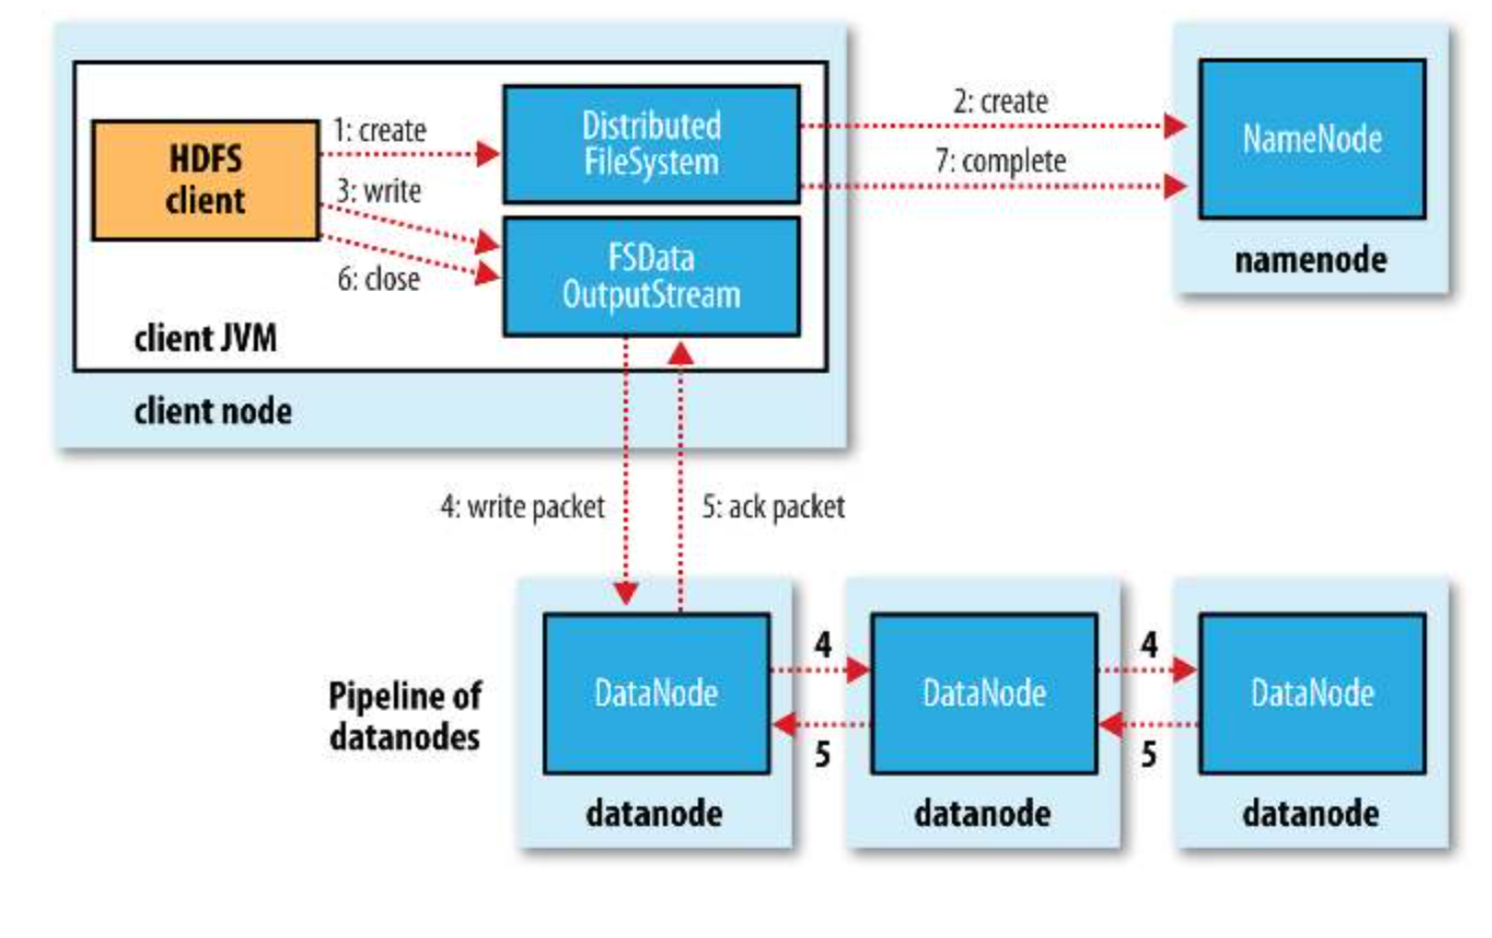

The client creates the file by calling create() on DistributedFileSystem. DistributedFileSystem makes an RPC call to the namenode to create a new file in the filesystem's namesparce, with no blocks associated with it. The namenode performs various checks to make sure the file soesn't already exist and that the client has the right permissions to create the file. If these checks pass, the namenode makes a record of the new file; otherwise, file creation fails and the client is thrown an IOException. The DistributedFileSystem returns an FSDataOutputStream for the client to start writing data to. Just as in the read case, FSDataOutputStream wraps a DFSOutputStream, which handles communication with the datanodes and namenode.

As the client writes data, the DFSOutputStream splits it into packtes, which it writes to an internal queue called the data queue. The data queue is consumed by the DataStreamer, which is responsible for asking the namenode to allocate new blcoks by picking a list of suitable datanodes to store the replicas. The list of datanodes forms a piepline, and here we'll assume the replication level is three, so there are three nodes in the pipeline. The DataStreamer streams the packets to the first datanode in the pipeline, which stores each packet and forwards it to the second datanode in the pipeline. Similarly, the second datanode stores the packet and forwards it to the third datanode in the pipeline.

The DFSOutputStream also maintains an internal queue of packets that are waiting to be acknowledged by datanodes, called the ack queue. A packet is removed from the ack queue only when it has been acknowledged by all the datanodes in the pipeline.